<a href="https://colab.research.google.com/github/kkfwees/cs230_2020/blob/master/CS230_MultiTask_RCNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-rkhqpu2t
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-rkhqpu2t
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267019 sha256=f36ba52157efed2553a5dae169370b4897b51a319985b1c2a832318172ed0daf
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ekyyp1s/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [0]:
#get all needed resources
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.utils.data

In [0]:
# mount data to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#if this does not run: create a shortcut to Eleni Shared CS230 drive 
logis = os. listdir('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/masks')[0:3]
logis += os. listdir('/content/drive/My Drive/CS230/data/multi_color_batch1_2_nonlogis_unzipped/masks')[0:3]
logis

['1009_640x640_labeled.png',
 '10260_640x640_labeled.png',
 '1052_640x640_labeled.png',
 '59060_640x640_nonlogis_labeled.png',
 '100320_640x640_nonlogis_labeled.png',
 '59137_640x640_nonlogis_labeled.png']

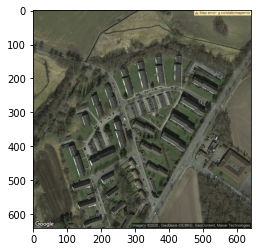

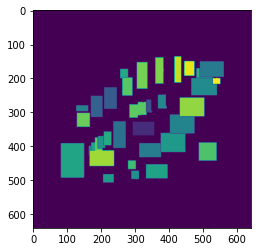

[  0  29  56  66  71  84  93  96  98 102 105 109 114 118 121 124 130 132
 138 139 146 157 163 167 168 169 170 175 179 182 189 194 206 218 226]
[[293, 328, 355, 367], [333, 263, 349, 300], [208, 227, 309, 496], [170, 252, 447, 415], [236, 327, 271, 404], [281, 151, 559, 441], [312, 391, 375, 431], [127, 280, 392, 389], [344, 307, 473, 390], [367, 249, 391, 288], [465, 200, 539, 249], [164, 398, 310, 495], [191, 370, 211, 404], [376, 361, 446, 416], [190, 374, 236, 505], [332, 453, 394, 493], [82, 389, 181, 491], [256, 172, 366, 256], [208, 199, 540, 411], [182, 171, 527, 374], [279, 442, 301, 466], [487, 389, 538, 441], [261, 198, 291, 250], [32, 270, 532, 632], [182, 375, 203, 410], [283, 276, 307, 315], [129, 302, 166, 342], [305, 153, 335, 230], [182, 139, 383, 411], [431, 199, 539, 311], [166, 412, 237, 457], [415, 136, 434, 212], [443, 150, 473, 192], [528, 200, 549, 216]]


In [0]:
#test the datasest class
test_img = Image.open('/content/drive/My Drive/CS230/data/multi_color_batch1_2_nonlogis_unzipped/unlabeled/59443_640x640_nonlogis.png').convert("RGB")
plt.imshow(test_img)
plt.show()
test_mask = Image.open('/content/drive/My Drive/CS230/data/multi_color_batch1_2_nonlogis_unzipped/masks/59443_640x640_nonlogis_labeled.png').convert("L")
plt.imshow(test_mask)
plt.show()

test_mask = np.array(test_mask)
# instances are encoded as different colors
test_obj_ids = np.unique(test_mask)
print(test_obj_ids)

# first id is the background, so remove it
test_obj_ids = test_obj_ids[1:]

test_masks = test_mask == test_obj_ids[:, None, None]

# get bounding box coordinates for each mask
test_num_objs = len(test_obj_ids)
test_boxes = []
for i in range(test_num_objs):
    pos = np.where(test_masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    test_boxes.append([xmin, ymin, xmax, ymax])


print(test_boxes)


In [0]:
class SatelliteMultiDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/unlabeled"))))
        self.imgs +=  list(sorted(os.listdir(os.path.join(root, "/content/drive/My Drive/CS230/data/multi_color_batch1_2_nonlogis_unzipped/unlabeled"))))
        self.masks = list(sorted(os.listdir(os.path.join(root,      "/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/masks"))))
        self.masks += list(sorted(os.listdir(os.path.join(root, "/content/drive/My Drive/CS230/data/multi_color_batch1_2_nonlogis_unzipped/masks"))))


    def __getitem__(self, idx):
        # load images and masks
        if self.imgs[idx].__contains__('nonlogis'):
          img_path = os.path.join(self.root,  "/content/drive/My Drive/CS230/data/multi_color_batch1_2_nonlogis_unzipped/unlabeled", self.imgs[idx])
          mask_path = os.path.join(self.root, "/content/drive/My Drive/CS230/data/multi_color_batch1_2_nonlogis_unzipped/masks", self.masks[idx])
        else:
          img_path = os.path.join(self.root,  "/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/unlabeled", self.imgs[idx])
          mask_path = os.path.join(self.root, "/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/masks", self.masks[idx])
        
        img = Image.open(img_path).convert("RGB")
        
  
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        # mask = Image.open(mask_path)
        #mask = np.array(mask)
        #print(mask.shape)
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)

        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            test_area = (ymax-ymin) * (xmax-xmin)
            if test_area > 0:
              boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        #label = 2 if non-logistics
        #label = 1 if logistics
        if self.imgs[idx].__contains__('nonlogis'):
          labels = torch.ones((num_objs,), dtype=torch.int64)
          labels = torch.add(labels,1)
        else:
          labels = torch.ones((num_objs,), dtype=torch.int64)
        
        masks = torch.as_tensor(masks, dtype=torch.uint8)        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
test_dataset2 = SatelliteMultiDataset('/content/drive/My Drive/CS230/data')
test_dataset2[300]

(<PIL.Image.Image image mode=RGB size=640x640 at 0x7FE42A68CEF0>,
 {'area': tensor([  3869.,  78727.,   6720., 107198.,  29330.,    575., 177750., 114475.,
            3283.,   2365.,   9540.,   6318.,  22784.,  58916., 184548.,  55440.,
           61740.,   3528.,   5453.,  12502.]),
  'boxes': tensor([[472., 353., 525., 426.],
          [219., 173., 406., 594.],
          [351., 366., 421., 462.],
          [325.,  46., 542., 540.],
          [122., 483., 541., 553.],
          [523., 554., 546., 579.],
          [ 88., 122., 483., 572.],
          [285.,  47., 526., 522.],
          [485., 464., 552., 513.],
          [ 89., 121., 132., 176.],
          [383., 391., 473., 497.],
          [137., 152., 218., 230.],
          [414., 318., 542., 496.],
          [341., 102., 484., 514.],
          [181.,  46., 545., 553.],
          [316.,  46., 492., 361.],
          [ 95.,  46., 340., 298.],
          [476., 512., 525., 584.],
          [505., 317., 546., 450.],
          [306.,  81.

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
# use our dataset and defined transformations
dataset = SatelliteMultiDataset('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped', get_transform(train=True))
dataset_test = SatelliteMultiDataset('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-80])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-80:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)
print(dataset[0])

(tensor([[[0.3961, 0.3451, 0.2000,  ..., 0.9725, 0.9725, 0.9725],
         [0.3020, 0.3961, 0.3961,  ..., 0.9725, 0.9725, 0.9725],
         [0.2314, 0.2706, 0.3961,  ..., 0.9725, 0.9725, 0.9725],
         ...,
         [0.4471, 0.4471, 0.4471,  ..., 0.1373, 0.1373, 0.1373],
         [0.4275, 0.4118, 0.4863,  ..., 0.1373, 0.1373, 0.1373],
         [0.3216, 0.3647, 0.4588,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.4275, 0.3961, 0.2588,  ..., 0.9294, 0.9294, 0.9294],
         [0.3529, 0.4275, 0.4275,  ..., 0.9294, 0.9294, 0.9294],
         [0.2941, 0.3294, 0.4275,  ..., 0.9294, 0.9294, 0.9294],
         ...,
         [0.4471, 0.4471, 0.4471,  ..., 0.1373, 0.1373, 0.1373],
         [0.4392, 0.4157, 0.4863,  ..., 0.1373, 0.1373, 0.1373],
         [0.3216, 0.3647, 0.4706,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.3647, 0.3216, 0.2039,  ..., 0.7333, 0.7333, 0.7333],
         [0.2706, 0.3647, 0.3647,  ..., 0.7333, 0.7333, 0.7333],
         [0.2039, 0.2510, 0.3647,  ..., 0.7333, 0.7333, 0

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has three classes only - background, logistics, non-logistics
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch: [0]  [  0/137]  eta: 0:03:27  lr: 0.000042  loss: 3.5073 (3.5073)  loss_classifier: 1.4863 (1.4863)  loss_box_reg: 0.1286 (0.1286)  loss_mask: 0.7764 (0.7764)  loss_objectness: 1.0235 (1.0235)  loss_rpn_box_reg: 0.0925 (0.0925)  time: 1.5147  data: 0.2803  max mem: 2630
Epoch: [0]  [ 10/137]  eta: 0:02:40  lr: 0.000409  loss: 3.5091 (3.9466)  loss_classifier: 1.0784 (1.0186)  loss_box_reg: 0.1286 (0.1743)  loss_mask: 1.3210 (1.4783)  loss_objectness: 0.4998 (0.9298)  loss_rpn_box_reg: 0.0925 (0.3456)  time: 1.2664  data: 0.0368  max mem: 2630
Epoch: [0]  [ 20/137]  eta: 0:02:24  lr: 0.000776  loss: 2.5039 (2.9351)  loss_classifier: 0.5118 (0.6788)  loss_box_reg: 0.1094 (0.1549)  loss_mask: 0.8454 (1.1485)  loss_objectness: 0.3686 (0.6711)  loss_rpn_box_reg: 0.0552 (0.2818)  time: 1.2241  data: 0.0127  max mem: 2630
Epoch: [0]  [ 30/137]  eta: 0:02:11  lr: 0.001144  loss: 1.6562 (2.6589)  loss_classifier: 0.3074 (0.5668)  loss_box_reg: 0.1280 (0.1600)  loss_mask: 0.6891 (1.0043) 

In [0]:
testset_idx = []

for i in range(len(indices[-80:])):
  _, temp_target = dataset_test[i]
  if np.asarray(temp_target["labels"])[0] == 1:
    testset_idx.append(i)
dataset_test_logis = torch.utils.data.Subset(dataset_test, testset_idx)
#for i in range
#testset_idx[1]
#dataset_test[testset_idx[1]]

data_loader_test_logis = torch.utils.data.DataLoader(
    dataset_test_logis, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)

evaluate(model, data_loader_test_logis, device=device)


In [0]:
evaluate(model, data_loader_test_logis, device=device)

creating index...
index created!


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Test:  [ 0/57]  eta: 0:00:54  model_time: 0.6437 (0.6437)  evaluator_time: 0.1797 (0.1797)  time: 0.9485  data: 0.1203  max mem: 2644
Test:  [56/57]  eta: 0:00:00  model_time: 0.3892 (0.3786)  evaluator_time: 0.1267 (0.1099)  time: 0.5069  data: 0.0058  max mem: 2644
Test: Total time: 0:00:28 (0.5018 s / it)
Averaged stats: model_time: 0.3892 (0.3786)  evaluator_time: 0.1267 (0.1099)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recal

In [0]:
# pick one image from the test set
img, _ = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [0]:
prediction[0]

{'boxes': tensor([[127.3593,  78.0394, 172.7891, 109.5697],
         [399.7941, 365.6495, 467.6590, 430.6461],
         [311.5114, 143.7527, 514.9089, 304.6590],
         [ 64.3652, 111.7804, 469.9757, 548.1870],
         [207.9279, 420.8983, 278.8781, 499.3573],
         [404.9744,  47.2420, 466.9879, 102.7127],
         [254.0415, 322.7293, 325.7307, 416.4240],
         [ 95.2382, 506.2938, 113.4058, 527.5114],
         [116.2744, 535.8994, 157.2266, 582.5823],
         [321.5797, 234.4949, 397.0282, 301.6079],
         [ 88.3751, 512.6642, 133.9532, 572.7822],
         [227.0400, 398.7480, 249.6114, 420.5112],
         [ 52.8274,  67.1179, 531.3257, 342.6462],
         [214.6741, 286.2912, 292.4536, 370.4786],
         [272.6237, 197.2920, 347.5504, 275.0772],
         [ 58.1623, 184.2378, 132.3038, 249.7107],
         [206.6417, 238.3504, 409.5470, 425.0818],
         [115.5605, 116.2536, 145.6576, 152.7003],
         [191.9747, 165.5143, 387.2779, 359.5400],
         [ 66.5567, 16

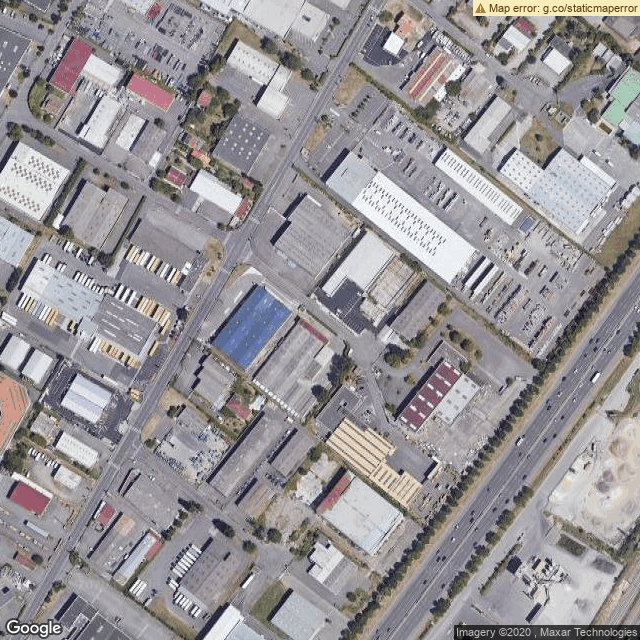

In [0]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

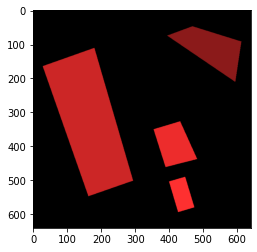

In [0]:
test_img = Image.open('/content/drive/My Drive/CS230/data/multi_color_batch1_2_unzipped/masks/2632_640x640_labeled.png').convert("RGB")
plt.imshow(test_img)

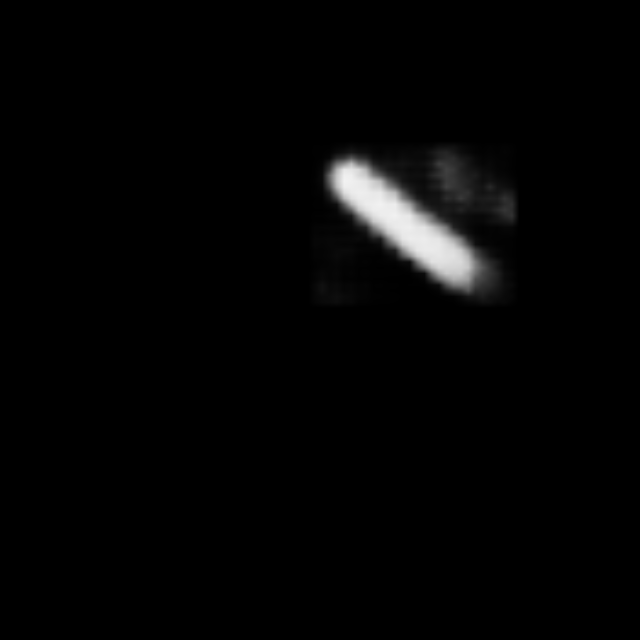

In [0]:
Image.fromarray(prediction[0]['masks'][2, 0].mul(255).byte().cpu().numpy())